In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np


In [82]:
df=pd.read_csv("/kaggle/input/correct/labels.csv")

In [83]:
df.head()

,image_name,lables
0,1.jpg,0
1,2.jpg,0
2,3.jpg,0
3,IMG_20240805_131928561_HDR.jpg,0
4,IMG_20240805_131930233.jpg,0


In [3]:
!pip install -q tensorflowjs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.6.1 requires cubinlinker, which is not installed.
cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.6.1 requires ptxcompiler, which is not installed.
cuml 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
keras-cv 0.9.0 requires keras-core, which is not installed.
cudf 24.6.1 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.5.0 which is incompatible.
distributed 2024.5.1 requires dask==2024.5.1, but you have dask 2024.7.0 which is incompatible.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 23.2 which is incompatible.
jupyterlab 4.2.3 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requir

In [31]:
import pandas as pd
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,BatchNormalization, Input, Activation, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import tensorflowjs as tfjs
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shutil

In [32]:
# Read in Y labels from CSV

label_csv = '/kaggle/input/correct/labels.csv'
df_Y = pd.read_csv(label_csv)

In [33]:
# Read images and write with label to arrays

images_path = "/kaggle/input/hahahhahahahhaha/img"
images = []
labels = []
image_files = os.listdir(images_path)
image_files.sort()

for image_path in image_files:
    image = cv.imread(os.path.join(images_path, image_path)).astype('float32') # Read image as a float32 object
    image = cv.resize(image, (64, 64)) # Resize to smaller size for faster train time
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Convert to greyscale for faster train time
    image /= 255.0 # Normalise data
    
    label_index = (image_path) # Get index into df_Y
    print(label_index)
    label = df_Y[df_Y['image_name'] == label_index].lables.values[0] # Get label value
    
    # Write into arrays
    images.append(image)
    labels.append(label)

1.jpg
2.jpg
3.jpg
IMG_20240805_131928561_HDR.jpg
IMG_20240805_131930233.jpg
IMG_20240805_131931873_HDR.jpg
IMG_20240805_131933222_HDR.jpg
IMG_20240805_131935078_HDR.jpg
IMG_20240805_131937339.jpg
IMG_20240805_131938439.jpg
IMG_20240805_131939729.jpg
IMG_20240805_131940417.jpg
IMG_20240805_131941186_HDR.jpg
IMG_20240805_131942187_HDR.jpg
IMG_20240805_131943045_HDR.jpg
IMG_20240805_131944427_HDR.jpg
IMG_20240805_131945347_HDR.jpg
IMG_20240805_131948087_HDR.jpg
IMG_20240805_131950908_HDR.jpg
IMG_20240805_131952292_HDR.jpg
IMG_20240805_131953756_HDR.jpg
IMG_20240805_131955993_HDR.jpg
IMG_20240805_132028280_HDR.jpg
IMG_20240805_132030965_HDR.jpg
IMG_20240805_132034472_HDR.jpg
IMG_20240805_132035619_HDR.jpg
IMG_20240805_132037094_HDR.jpg
IMG_20240805_132040249_HDR.jpg
IMG_20240805_132043103_HDR.jpg
IMG_20240805_132044770_HDR.jpg
IMG_20240805_132046492_HDR.jpg
IMG_20240805_132048320_HDR.jpg
IMG_20240805_132049672_HDR.jpg
IMG_20240805_132050625_HDR.jpg
IMG_20240805_132052827_HDR.jpg
IMG_202408

In [34]:
# Convert to np arrays

images = np.array(images)
labels = np.array(labels)

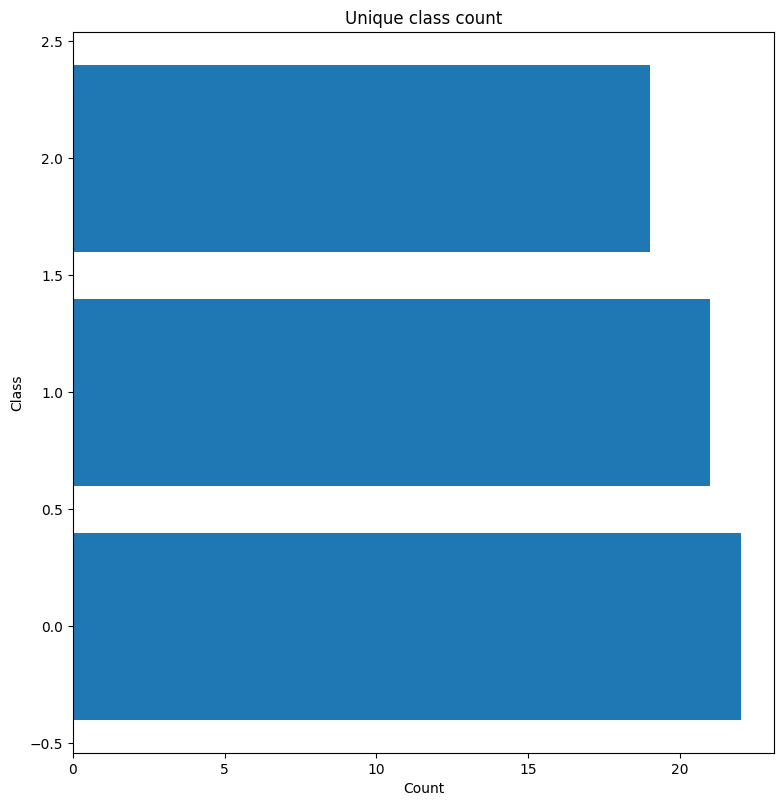

In [35]:
# Visualise the count for each class

unique_class, class_count = np.unique(labels, return_counts=True)

plt.figure(figsize=(8,8))
plt.barh(unique_class, class_count)
plt.tight_layout(pad=2.0)
plt.title("Unique class count")
plt.xlabel("Count")
plt.ylabel("Class")
plt.show()

In [36]:
# Add greyscale dimension for cnn

images = np.expand_dims(images, axis=-1) 

In [37]:
# One hot encode the labels

encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))

In [38]:
# Define a custom decoder

decoder = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]

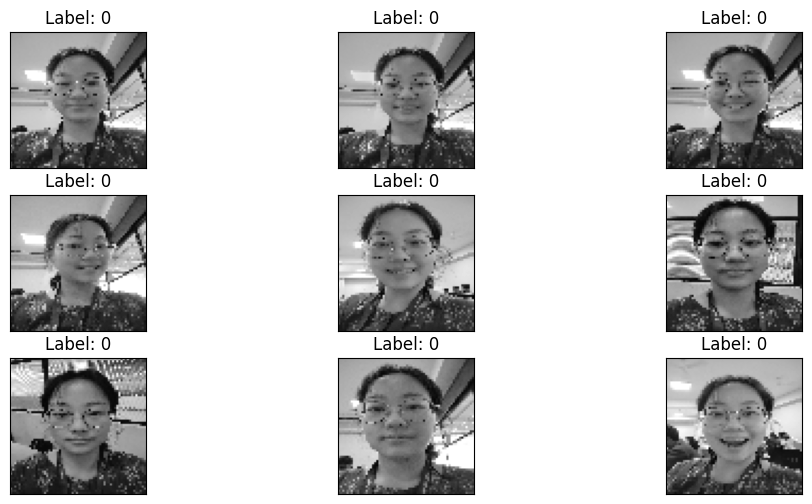

In [39]:
# Plot 9 random images for visualisation

def display_images(rows, cols, images, labels, decoder):
    _, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Label: {decoder[np.where(labels[i]==1)[0][0]]}")
        
display_images(3, 3, images, labels, decoder)

In [40]:
# Randomly shuffle the data

images, labels = shuffle(images, labels, random_state=0)

In [41]:
# Split the data into train, test and validation sets (70, 15, 15)

X_train, X_temp, Y_train, Y_temp = train_test_split(images, labels, test_size=0.3, random_state=0)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=0)

In [42]:
# Define augmentation generator

datagen = ImageDataGenerator(
    rotation_range=15,    
    width_shift_range=0.1,  
    height_shift_range=0.2,
    zoom_range= 0.2, 
    shear_range=0.2,               
    fill_mode='nearest',        
)

In [43]:
# Load augmented data into arrays

augmented_arr_X = []
augmented_arr_Y = []
number_of_augmentation = 5

for i in range(len(X_train)):
    image_expanded = np.expand_dims(X_train[i], axis=0)  
    aug_iter = datagen.flow(image_expanded, batch_size=1)
    augmented_images = [next(aug_iter)[0] for _ in range(number_of_augmentation)]
    augmented_arr_X.extend(augmented_images)  
    augmented_arr_Y.extend([Y_train[i]] * number_of_augmentation) 

In [44]:
# Set augmented data up for training

X_train = np.array(augmented_arr_X)
Y_train = np.array(augmented_arr_Y)

In [45]:
# Shuffle again

X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

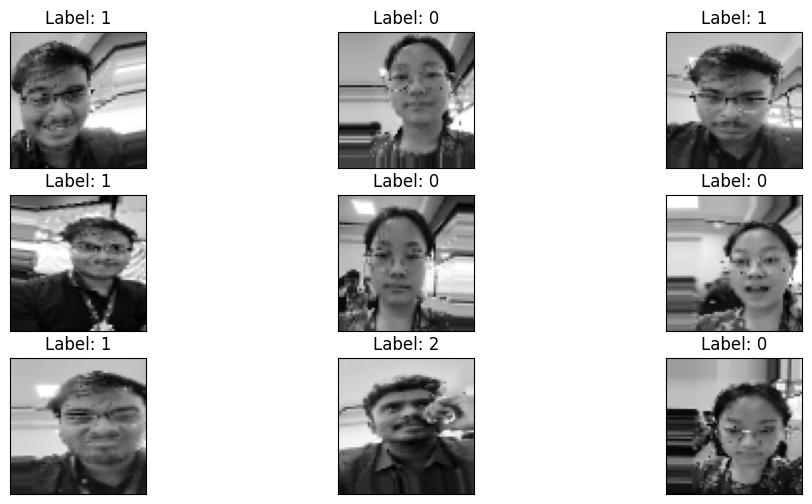

In [46]:
# Display augmented images

display_images(3, 3, X_train, Y_train, decoder)

In [47]:
# Define model

model = Sequential([
    Input(shape=(64, 64, 1)),
    
    Conv2D(512, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.1),
    
    Dense(1024, activation='relu'),
    
    Dense(512, activation='relu'),
    Dropout(0.1),
    
    Dense(256, activation='sigmoid'),
    
    Dense(3, activation='softmax')
])

In [48]:
# Visualise model summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 60, 60, 512)       13312     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 512)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 256)       1179904   
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 256)       590080    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 256)        

In [49]:
# Compile and train the model

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_val,Y_val))

Epoch 1/20
14/14 [==============================] - 3s 48ms/step - loss: 1.2623 - accuracy: 0.3302 - val_loss: 1.1244 - val_accuracy: 0.2222
Epoch 2/20
14/14 [==============================] - 0s 24ms/step - loss: 1.0896 - accuracy: 0.4093 - val_loss: 1.1438 - val_accuracy: 0.3333
Epoch 3/20
14/14 [==============================] - 0s 24ms/step - loss: 1.0326 - accuracy: 0.4744 - val_loss: 0.7221 - val_accuracy: 0.4444
Epoch 4/20
14/14 [==============================] - 0s 24ms/step - loss: 0.8274 - accuracy: 0.5721 - val_loss: 2.0637 - val_accuracy: 0.3333
Epoch 5/20
14/14 [==============================] - 0s 24ms/step - loss: 0.6953 - accuracy: 0.6465 - val_loss: 0.4982 - val_accuracy: 0.7778
Epoch 6/20
14/14 [==============================] - 0s 23ms/step - loss: 0.6981 - accuracy: 0.6512 - val_loss: 0.3593 - val_accuracy: 0.8889
Epoch 7/20
14/14 [==============================] - 0s 24ms/step - loss: 0.4079 - accuracy: 0.8837 - val_loss: 0.3331 - val_accuracy: 0.8889
Epoch 8/20
14

In [50]:
# Train and validation accuracy

train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

[]

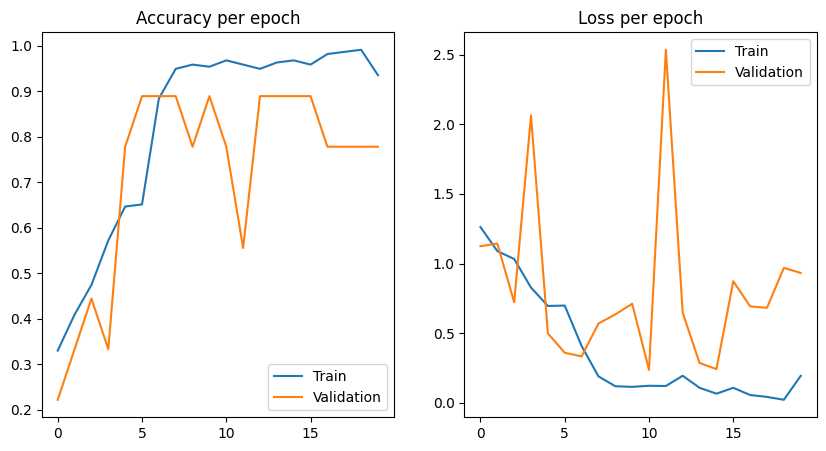

In [51]:
# Plot the accuracy and loss

_, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))

# Plot accuracy
axes[0].plot(train_accuracy)
axes[0].plot(validation_accuracy)
axes[0].legend(['Train', 'Validation'])
axes[0].set_title("Accuracy per epoch")

# Plot loss
axes[1].plot(train_loss)
axes[1].plot(validation_loss)
axes[1].legend(['Train', 'Validation'])
axes[1].set_title("Loss per epoch")

plt.plot()

In [52]:
# Get test predictions

Y_pred = model.predict(X_test)

1/1 [==============================] - 0s 105ms/step


In [53]:
# Find accuracy of the model

y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9000


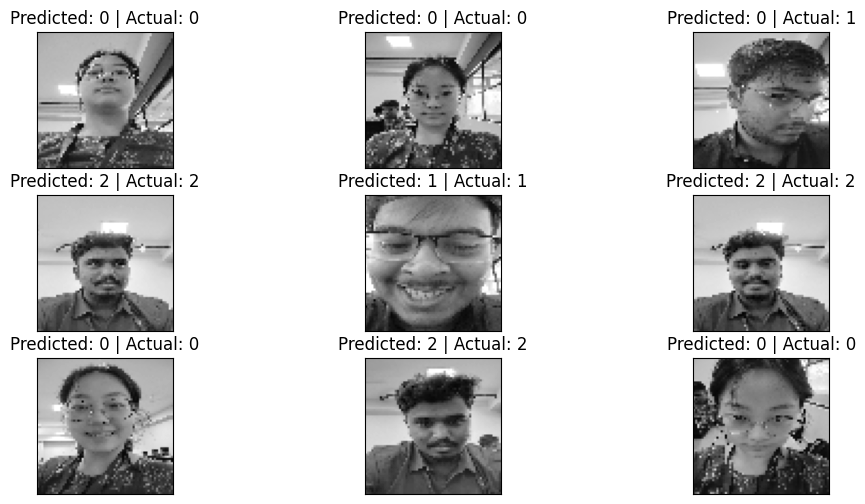

In [54]:
_, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_test[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Predicted: {decoder[y_pred_classes[i]]} | Actual: {decoder[y_true[i]]}")

In [27]:
model.save('face_recognition_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
import tensorflow as tf

# Assuming 'model' is your trained Keras model

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('face_recognition_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved as TFLite format")

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 17, Total Ops 34, % non-converted = 50.00 %
 * 17 ARITH ops

- arith.constant:   17 occurrences  (f32: 16, i32: 1)



  (f32: 3)
  (f32: 5)
  (f32: 1)
  (f32: 3)
  (f32: 1)
  (f32: 1)


Model saved as TFLite format


In [30]:
import numpy as np
import cv2
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="face_recognition_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define the decoder (same as in your training script)
decoder = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]

# Function to preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (64, 64))
    normalized = resized.astype('float32') / 255.0
    return normalized, img

# Function to make prediction
def predict(image):
    input_data = np.expand_dims(image, axis=[0, -1])
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Test on a sample image
image_path = "/kaggle/input/hahahhahahahhaha/img/IMG_20240805_131933222_HDR.jpg"  # Replace with actual path
processed_image, original_image = preprocess_image(image_path)

# Make prediction
prediction = predict(processed_image)
predicted_class = decoder[np.argmax(prediction)]

print(f"Predicted class: {predicted_class}")

# Display result on the image
cv2.putText(original_image, f"Predicted: {predicted_class}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Save the resulting image
cv2.imwrite('/kaggle/working/result.jpg', original_image)
print("Result saved as 'result.jpg'")

Predicted class: 0
Result saved as 'result.jpg'
